In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
GOOGLE_MODEL_NAME = os.getenv("GOOGLE_MODEL_NAME", "gemini-pro") 

from langchain_google_genai import ChatGoogleGenerativeAI

c:\CentennialCode\AI-Tutor-agentic-rag\flask-server\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, ChatMessage



### Load document content

In [3]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os

def load_document_content(file_path):
    try:
        # Load documents from the file using TextLoader
        loader = TextLoader(file_path)
        documents = loader.load()

        # Split text into smaller chunks
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        docs = text_splitter.split_documents(documents)

        # Concatenate the chunks into a single context string
        context = "\n".join([doc.page_content for doc in docs])
        return context
    except Exception as e:
        return f"Error loading document content: {e}"

file_name = 'topic_material.txt'
file_path = os.path.join("data", file_name)
context = load_document_content(file_path)



In [4]:
context

'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for a given entity you may define a generic behavior, and then\nredefine it for more specialized entities that 

In [5]:
SUMMARY_PROMPT = """
Create a summary of the topics included in the context.
context: {context}
"""

GREETING_PROMPT = """
You are an AI Tutor. You are given a topic and a subject.
You need to create a greeting message for the student,
asking them what they want to learn based on the subject, topic and content summary.
Keep the greeting short and concise.

Subject: {subject}
Topic: {topic}
Content summary of the topic: {summary}
"""

QUESTION_GUARDING_PROMPT = """
You are an AI Tutor. Based on the content summary of the topic, 
you need to decide if the student's question is related to the content summary.
For educational purpose, it is ok to be related but not exactly the same topic.
If it is, respond "Pass".  
If it is not, respond "Fail" 

Student Question: {question}
Content summary of the topic: {summary}
"""

QUESTION_ANSWERING_PROMPT = """
You are an AI Tutor. You are given a question and a topic.
You need to answer the question based on the context.
After finishing explaining, ask the student a question to check their understanding.

Question: {question}
Context: {context}
"""

check_question_answer_prompt = """
You are an AI Tutor evaluating a student's answer. 
Compare their response to the context, consider **ONLY the latest answer**,
determine if it answering the question correctly, demonstrates understanding of the concept.
If it is, respond "Correct". If it is not, respond "Wrong".

Question and Answer:
{question_answer_context}

Reference Context: 
{context}
"""


hints_prompt = """
You are an AI Tutor. Based on the question and student's answer, 
understand the student's misconcept and provide hints to the student to help them answer the question.

Question Answer context: {question_answer_context}
"""


intermediate_summary_prompt = """
You are an AI Tutor. Based on all the previous conversations with student, create a summary of the session.
Focus on the key concepts and ideas that the student has learnt.
At the end of the summary, ask the student if there any other questions.

Question Answer context: {question_answer_context}
"""

any_further_question_prompt = """
Based on the student's answer, determine if the student has any further questions.
If the student has any further questions, respond "Yes". If not, respond "No".

Student Answer: {student_answer}
"""

explain_answer_prompt = """
You are an AI Tutor. 
First, thanks for the effort of answering the question.
Based on the question and student's answer, 
explain the correct answer to the student. 
Keep the explanation short and concise. 
Forcus on the key concepts and ideas based on student's wrong answer.

Question Answer context: {question_answer_context}
"""


session_summary_prompt = """
You are an AI Tutor. Based on all the previous conversations with student, create a concise summary of the session.
Focus on the key concepts and ideas that the student has learnt.

Messages: {messages}
"""



In [6]:
def print_debug(prefix, messages_or_text, separator="="*50):
    """Helper function to print debug information"""
    print(f"\n{separator}\n{prefix}:")
    if isinstance(messages_or_text, list):
        for msg in messages_or_text:
            print(f"\nRole: {msg.type}\nContent: {msg.content}\n")
    else:
        print(messages_or_text)
    print(separator)

In [7]:
from typing import TypedDict, Annotated
from datetime import timedelta,datetime
from langgraph.graph.message import add_messages


llm = ChatGoogleGenerativeAI(model="gemini-pro")

class AgentState(TypedDict):
    subject: str
    topic: str
    context: str
    summary: str
    messages: Annotated[list, add_messages]
    answer_trials: int
    start_time: datetime
    duration_minutes: int
    # time_out: bool

     
def create_summary(state: AgentState):
    response = llm.invoke(SUMMARY_PROMPT.format(context=state["context"]))
    return {"summary": response.content}

def greeting(state: AgentState):
    subject = state["subject"]
    topic = state["topic"]
    messages = state["messages"]
    summary = state["summary"]

    greeting_prompt = GREETING_PROMPT.format(subject=subject, topic=topic, summary=summary)
    messages= [HumanMessage(content=greeting_prompt.format(subject=subject, topic=topic))]
    response = llm.invoke(messages)
    return {"messages": response}

def student_input(state:AgentState):
    # print(state["messages"][-1].content)
    return state

#helper function
def time_out(state:AgentState):
    current_time = datetime.now()
    start_time = state["start_time"]
    duration_minutes = state["duration_minutes"]    
    return (current_time - start_time) > timedelta(minutes=duration_minutes)

def question_guarding(state:AgentState):
    if time_out(state):
        return "TimeOut"    
    question = state["messages"][-1].content
    summary = state["summary"]
    response = llm.invoke(QUESTION_GUARDING_PROMPT.format(question=question, summary=summary))
    content = response.content
    if content.startswith("Pass"):
        return "Pass"
    else:
        return "Fail"

def reask_question(state:AgentState):
    return {"messages": [AIMessage(content="Your question is not related to the topic. Please ask a question related to the topic.")]}


def llm_answer_question(state:AgentState):
    # print("Answer the question: ", state["messages"][-1].content)
    question = state["messages"][-1].content
    response = llm.invoke(QUESTION_ANSWERING_PROMPT.format(question=question, context = context))
    result=response.content
    return {"messages": [AIMessage(content=result)]}

def student_answer_question(state:AgentState):
    # print(state["messages"][-1].content)
    return state

#helper function
#TODO: use trim_message library
def get_question_answer_context(state:AgentState):
    answer_trials = state["answer_trials"]
    number_of_related_messages = (answer_trials+1)*2
    question_answer_context = state["messages"][-number_of_related_messages:]
    # print(f"number_of_related_messages: {number_of_related_messages}")
    # print(f"question_answer_context for get_question_answer_context: {question_answer_context}")
    return question_answer_context

#TODO: need further verify if anwser_trials is correct
def further_question_correctness(state:AgentState, max_trials=3):
    if time_out(state):
        return "TimeOut"
    
    answer_trials = state["answer_trials"]
    if answer_trials >= max_trials:
        return "Stop"
        
    question_answer_context = get_question_answer_context(state)
    context = state["context"]
    
    response = llm.invoke(check_question_answer_prompt.format(
        question_answer_context=question_answer_context, 
        context=context
    ))
    
    result = response.content.strip()
    return "Correct" if result.startswith("Correct") else "Wrong"
    #need to add one trials for answer_trials

def tell_student_answer_is_correct(state:AgentState):
    return {"messages": [AIMessage(content="Your answer is correct.")]}

def add_wrong_answer_trials(state:AgentState):
    return {"answer_trials": state["answer_trials"] + 1}

def hints(state:AgentState):
    question_answer_context = get_question_answer_context(state)
    print(f"question_answer_context for hints: {question_answer_context}")
    response = llm.invoke(hints_prompt.format(question_answer_context=question_answer_context))
    result = response.content
    return {"messages": [AIMessage(content=result)]}

def explain_answer(state:AgentState):
    question_answer_context = get_question_answer_context(state)
    response = llm.invoke(explain_answer_prompt.format(question_answer_context=question_answer_context))
    result = response.content
    return {"messages": [AIMessage(content=result)]}

def intermediate_summary(state:AgentState):
    question_answer_context = get_question_answer_context(state)
    response = llm.invoke(intermediate_summary_prompt.format(question_answer_context=question_answer_context))
    result = response.content
    return {"messages": [AIMessage(content=result)]}

def student_answer_if_any_further_question(state:AgentState):
    return state

def any_further_question(state:AgentState):
    if time_out(state):
        return "TimeOut"
    student_answer = state["messages"][-1].content
    response = llm.invoke(any_further_question_prompt.format(student_answer=student_answer))
    result = response.content
    if result.startswith("Yes"):
        return "Yes"
    else:
        return "No"
    
def time_out_message(state:AgentState):
    return {"messages": [AIMessage(content="Time is up. We will summarize the session now.")]}

def session_summary(state:AgentState):
    messages = state["messages"]
    response = llm.invoke(session_summary_prompt.format(messages=messages))
    result = response.content
    return {"messages": [AIMessage(content=result)]}

def ask_new_question(state:AgentState):
    return {"messages": [HumanMessage(content="What is your next question?")]}


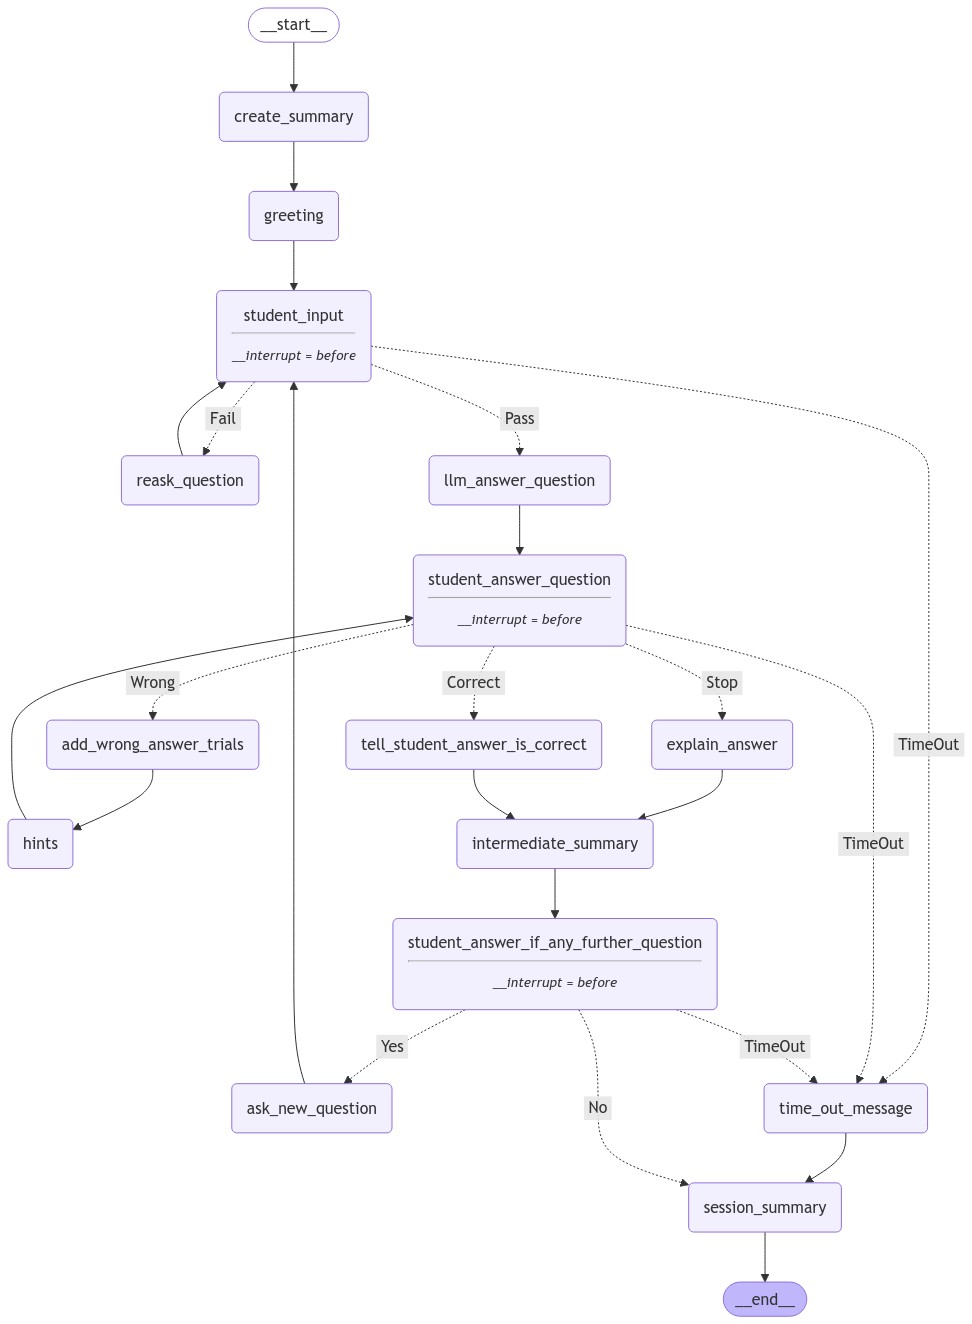

In [8]:
from langgraph.graph import START,END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("create_summary", create_summary)
workflow.add_node("greeting", greeting)
workflow.add_node("student_input", student_input)
workflow.add_node("reask_question", reask_question)
workflow.add_node("llm_answer_question", llm_answer_question)
workflow.add_node("student_answer_question", student_answer_question)
workflow.add_node("add_wrong_answer_trials", add_wrong_answer_trials)
workflow.add_node("tell_student_answer_is_correct", tell_student_answer_is_correct)
workflow.add_node("hints", hints)
workflow.add_node("explain_answer", explain_answer)
workflow.add_node("intermediate_summary", intermediate_summary)
workflow.add_node("student_answer_if_any_further_question", student_answer_if_any_further_question)
workflow.add_node("session_summary", session_summary)
workflow.add_node("ask_new_question", ask_new_question)
workflow.add_node("time_out_message", time_out_message)

# further_question_correctness)
workflow.add_edge(START, "create_summary")
workflow.add_edge("create_summary", "greeting")
workflow.add_edge("greeting", "student_input")
workflow.add_edge("reask_question", "student_input")

workflow.add_conditional_edges(
    "student_input",
    question_guarding,
    {
        "TimeOut": "time_out_message",
        "Pass": "llm_answer_question",
        "Fail": "reask_question"
    }
)

workflow.add_edge("llm_answer_question", "student_answer_question")

workflow.add_conditional_edges(
    "student_answer_question",
    further_question_correctness,
    {
        "TimeOut": "time_out_message",
        "Correct": "tell_student_answer_is_correct",
        "Wrong": "add_wrong_answer_trials",
        "Stop": "explain_answer"
    }
)

workflow.add_edge("tell_student_answer_is_correct", "intermediate_summary")

workflow.add_edge("add_wrong_answer_trials", "hints")
workflow.add_edge("hints", "student_answer_question")
workflow.add_edge("explain_answer", "intermediate_summary")
workflow.add_edge("intermediate_summary", "student_answer_if_any_further_question")

workflow.add_conditional_edges(
    "student_answer_if_any_further_question",
    any_further_question,
    {
        "TimeOut": "time_out_message",
        "Yes": "ask_new_question",
        "No": "session_summary"
    }
)

workflow.add_edge("time_out_message", "session_summary")
workflow.add_edge("ask_new_question", "student_input")
workflow.add_edge("session_summary", END)

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
app = workflow.compile(checkpointer=memory, interrupt_before=["student_input", "student_answer_question", "student_answer_if_any_further_question"])

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [9]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'create_summary': Node(id='create_summary', name='create_summary', data=create_summary(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'greeting': Node(id='greeting', name='greeting', data=greeting(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'student_input': Node(id='student_input', name='student_input', data=student_input(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata={'__interrupt': 'before'}), 'reask_question': Node(id='reask_question', name='reask_question', data=reask_question(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'llm_answer_question': Node(id='llm_answer_questi

In [9]:
graph = app.get_graph()
    # Convert the graph to a dictionary structure
graph_data = {
    'nodes': {
        node_id: {
            'name': node.name,
            'metadata': node.metadata
        }
        for node_id, node in graph.nodes.items()
    },
    'edges': [
        {
            'source': edge.source,
            'target': edge.target,
            'data': edge.data,
            'conditional': edge.conditional
        }
        for edge in graph.edges
    ]
}
print(graph_data)

{'nodes': {'__start__': {'name': '__start__', 'metadata': None}, 'create_summary': {'name': 'create_summary', 'metadata': None}, 'greeting': {'name': 'greeting', 'metadata': None}, 'student_input': {'name': 'student_input', 'metadata': {'__interrupt': 'before'}}, 'reask_question': {'name': 'reask_question', 'metadata': None}, 'llm_answer_question': {'name': 'llm_answer_question', 'metadata': None}, 'student_answer_question': {'name': 'student_answer_question', 'metadata': {'__interrupt': 'before'}}, 'add_wrong_answer_trials': {'name': 'add_wrong_answer_trials', 'metadata': None}, 'tell_student_answer_is_correct': {'name': 'tell_student_answer_is_correct', 'metadata': None}, 'hints': {'name': 'hints', 'metadata': None}, 'explain_answer': {'name': 'explain_answer', 'metadata': None}, 'intermediate_summary': {'name': 'intermediate_summary', 'metadata': None}, 'student_answer_if_any_further_question': {'name': 'student_answer_if_any_further_question', 'metadata': {'__interrupt': 'before'}}

## New question answering flow

In [11]:
def human_input(app, thread, user_input, node=None):
    if node:
        app.update_state(thread, {"messages": HumanMessage(content=user_input)}, as_node=node)
    else:
        app.update_state(thread, {"messages": HumanMessage(content=user_input)})

    # We can check the state
    print("--State after update--")
    print(app.get_state(thread))
    print("--Next node=-")
    print(app.get_state(thread).next)
    print("--Node values--")
    print(app.get_state(thread).values)
    print("--Messages--")
    for message in app.get_state(thread).values["messages"]:
        message.pretty_print()

def run_graph(app, thread):
    for event in app.stream(None, thread, stream_mode="values"):
        # print(event)
        event["messages"][-1].pretty_print()
        
    # Get the current state
    current_state = app.get_state(thread)
    print("--Current Node--")
    print(current_state.next)  # This will show the next node to be executed


### test with invoke

In [12]:
import json

memory = MemorySaver()
app = workflow.compile(checkpointer=memory, interrupt_before=["student_input", "student_answer_question", "student_answer_if_any_further_question"])


# Input
initial_input = {"subject":"Java", "topic": "Polymorphism in Java", "context":"Polymorphism in Java", "summary": "", "messages": [], "answer_trials": 0, "start_time": datetime.now(), "duration_minutes": 30}

# Thread
thread = {"configurable": {"thread_id": "1"}}


#test with invoke
response = app.invoke(initial_input, thread, stream_mode="values")

print(response)


{'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Polymorphism in Java', 'summary': "**Polymorphism in Java**\n\n* **Concept of polymorphism:** Ability for objects to behave differently based on their type\n* **Method overriding:** Declaring methods with the same name and signature in subclasses that provide different implementations\n* **Method overloading:** Declaring methods with the same name but different parameters in the same class\n* **Dynamic method binding:** The method to be executed is determined at runtime based on the object's type\n* **Benefits of polymorphism:**\n    * Code reusability\n    * Maintainability\n    * Extensibility\n* **Types of polymorphism:**\n    * Compile-time polymorphism (method overloading)\n    * Runtime polymorphism (method overriding)\n* **Example code demonstrating polymorphism:** Creating a hierarchy of classes and overriding methods to exhibit different behaviors", 'messages': [AIMessage(content="Hi there! Welcome to your Java s

In [13]:
app.get_state(thread)


StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Polymorphism in Java', 'summary': "**Polymorphism in Java**\n\n* **Concept of polymorphism:** Ability for objects to behave differently based on their type\n* **Method overriding:** Declaring methods with the same name and signature in subclasses that provide different implementations\n* **Method overloading:** Declaring methods with the same name but different parameters in the same class\n* **Dynamic method binding:** The method to be executed is determined at runtime based on the object's type\n* **Benefits of polymorphism:**\n    * Code reusability\n    * Maintainability\n    * Extensibility\n* **Types of polymorphism:**\n    * Compile-time polymorphism (method overloading)\n    * Runtime polymorphism (method overriding)\n* **Example code demonstrating polymorphism:** Creating a hierarchy of classes and overriding methods to exhibit different behaviors", 'messages': [AIMessage(content="Hi there! W

In [14]:
app.get_state(thread).values


{'subject': 'Java',
 'topic': 'Polymorphism in Java',
 'context': 'Polymorphism in Java',
 'summary': "**Polymorphism in Java**\n\n* **Concept of polymorphism:** Ability for objects to behave differently based on their type\n* **Method overriding:** Declaring methods with the same name and signature in subclasses that provide different implementations\n* **Method overloading:** Declaring methods with the same name but different parameters in the same class\n* **Dynamic method binding:** The method to be executed is determined at runtime based on the object's type\n* **Benefits of polymorphism:**\n    * Code reusability\n    * Maintainability\n    * Extensibility\n* **Types of polymorphism:**\n    * Compile-time polymorphism (method overloading)\n    * Runtime polymorphism (method overriding)\n* **Example code demonstrating polymorphism:** Creating a hierarchy of classes and overriding methods to exhibit different behaviors",
 'messages': [AIMessage(content="Hi there! Welcome to your Ja

In [17]:
app.update_state(thread, {"duration_minutes": 15})


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdbabc-f936-6caa-8004-4904479a6ab3'}}

In [18]:
app.get_state(thread).values


{'subject': 'Java',
 'topic': 'ALL',
 'context': 'Polymorphism in Java',
 'summary': "**Polymorphism in Java**\n\n* **Concept of polymorphism:** Ability for objects to behave differently based on their type\n* **Method overriding:** Declaring methods with the same name and signature in subclasses that provide different implementations\n* **Method overloading:** Declaring methods with the same name but different parameters in the same class\n* **Dynamic method binding:** The method to be executed is determined at runtime based on the object's type\n* **Benefits of polymorphism:**\n    * Code reusability\n    * Maintainability\n    * Extensibility\n* **Types of polymorphism:**\n    * Compile-time polymorphism (method overloading)\n    * Runtime polymorphism (method overriding)\n* **Example code demonstrating polymorphism:** Creating a hierarchy of classes and overriding methods to exhibit different behaviors",
 'messages': [AIMessage(content="Hi there! Welcome to your Java session on pol

In [11]:
app.get_state(thread).next[0]



'student_input'

In [38]:
# def parse_state_snapshot(state_snapshot):
#     # Extract values
#     values = state_snapshot.values
#     subject = values.get('subject')
#     topic = values.get('topic')
#     context = values.get('context')
#     summary = values.get('summary')
#     messages = values.get('messages', [])
#     answer_trials = values.get('answer_trials')
#     start_time = values.get('start_time')
#     duration_minutes = values.get('duration_minutes')

#     # Convert messages
    
#     parsed_messages = [
#     {"role": "ai", "content": message.content} if isinstance(message, AIMessage)
#     else {"role": "human", "content": message.content}
#     for message in messages
#     ]

#     # Extract next action
#     next_action = state_snapshot.next

#     # Extract config
#     config = state_snapshot.config

#     # Extract metadata
#     metadata = state_snapshot.metadata

#     # Extract tasks
#     tasks = []
#     for task in state_snapshot.tasks:
#         parsed_task = {
#             'id': task.id,
#             'name': task.name,
#             'path': task.path,
#             'error': task.error,
#             'interrupts': task.interrupts,
#             'state': task.state,
#             'result': task.result
#         }
#         tasks.append(parsed_task)

#     # Build the frontend-friendly data structure
#     stete_json_data = {
#         'subject': subject,
#         'topic': topic,
#         'context': context,
#         'summary': summary,
#         'messages': parsed_messages,
#         'answer_trials': answer_trials,
#         'start_time': start_time.isoformat() if isinstance(start_time, datetime) else str(start_time),
#         'duration_minutes': duration_minutes,
#         'next_action': next_action,
#         'config': config,
#         'metadata': metadata,
#         'created_at': state_snapshot.created_at,
#         'parent_config': state_snapshot.parent_config,
#         'tasks': tasks
#     }

#     return stete_json_data


def parse_state_snapshot(state_snapshot):
    # Recursive function to make data JSON-serializable
    def make_json_serializable(obj):
        if isinstance(obj, dict):
            return {k: make_json_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [make_json_serializable(element) for element in obj]
        elif isinstance(obj, tuple):
            return [make_json_serializable(element) for element in obj]
        elif isinstance(obj, datetime):
            return obj.isoformat()
        elif isinstance(obj, AIMessage):
            return {
                'role': 'ai',
                'content': obj.content
            }
        elif isinstance(obj, HumanMessage):
            return {
                'role': 'human',
                'content': obj.content
            }
        elif hasattr(obj, '__dict__'):
            return make_json_serializable(vars(obj))
        elif obj is None:
            return None
        else:
            return obj
        
            # Use the recursive function to process the entire state snapshot
    state_json = make_json_serializable(state_snapshot)
    return state_json


In [41]:
state_snapshot = app.get_state(thread)

# Parse the state snapshot
frontend_data = parse_state_snapshot(state_snapshot)

# Convert to JSON for frontend
frontend_json = json.dumps(frontend_data, indent=4)
print(frontend_json)


[
    {
        "subject": "Java",
        "topic": "Polymorphism in Java",
        "context": "Polymorphism in Java",
        "summary": "**Polymorphism in Java**\n\n**Topics Included:**\n\n* **Introduction to Polymorphism:**\n    * Definition and benefits\n* **Types of Polymorphism:**\n    * Method overriding\n    * Method overloading\n    * Parametric polymorphism (generics)\n* **How Polymorphism Works:**\n    * Inheritance and method binding\n    * Dynamic method dispatch\n* **Benefits of Polymorphism:**\n    * Code reusability\n    * Maintainability\n    * Extensibility\n* **Implementing Polymorphism in Java:**\n    * Creating base and derived classes\n    * Overriding and overloading methods\n* **Common Pitfalls and Best Practices:**\n    * Overriding vs. overloading\n    * Avoiding ambiguity and confusion\n* **Advanced Topics:**\n    * Covariance and contravariance in generics\n    * Abstract classes and interfaces for polymorphism",
        "messages": [
            {
         

In [23]:
import json
from langchain.schema import AIMessage, HumanMessage

# Example messages
messages = [AIMessage("hello"), HumanMessage("hi")]

# Convert to JSON serializable format
messages_json = [
    {"role": "ai", "content": message.content} if isinstance(message, AIMessage)
    else {"role": "human", "content": message.content}
    for message in messages
]

# Convert to JSON string (optional, depends on how your REST API handles JSON)
messages_json_string = json.dumps(messages_json)

# Now, messages_json_string can be passed through the API
print(messages_json_string)


[{"role": "ai", "content": "hello"}, {"role": "human", "content": "hi"}]


In [13]:
human_input(app, thread, user_input="what is python decorator?")

--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Polymorphism in Java', 'summary': '**Polymorphism in Java**\n\n* **Overview:**\n    * Concept of polymorphism and its significance in Java\n* **Types of Polymorphism:**\n    * Compile-time polymorphism (method overloading)\n    * Runtime polymorphism (method overriding)\n* **Method Overloading:**\n    * Creating methods with the same name but different parameters\n    * Java compiler resolves which method to call based on argument types\n* **Method Overriding:**\n    * Defining methods with the same name and signature in subclasses\n    * Overridden method in the subclass replaces the implementation of the parent class\n* **Advantages of Polymorphism:**\n    * Code flexibility and reusability\n    * Promotes code maintainability and extensibility\n* **Examples:**\n    * Overriding toString() method in subclasses for customized object printing\n    * Creating polymorphic lists or

In [113]:
human_input(app, thread, user_input="what is python decorator?", node="student_input")

--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Polymorphism in Java', 'summary': '**Topics:**\n\n* **Concept of Polymorphism:**\n    * Meaning and benefits\n* **Types of Polymorphism:**\n    * Method overriding\n    * Overloading\n* **Method Overriding:**\n    * Creating subclasses with different implementations\n* **Method Overloading:**\n    * Creating methods with the same name but different parameters\n* **Static and Dynamic Binding:**\n    * How objects are resolved to methods at runtime\n* **Advantages and Disadvantages of Polymorphism:**\n    * Benefits like code reusability and extensibility\n    * Potential drawbacks like complexity and ambiguity', 'messages': [AIMessage(content="Hi there! Welcome to your Java learning session. Today, we'll be exploring the topic of Polymorphism in Java. We'll cover concepts like method overriding, overloading, static and dynamic binding, and discuss the advantages and disadvantages

In [115]:
#test with invoke
response = app.invoke(None, thread, stream_mode="values")

print(response)

{'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Polymorphism in Java', 'summary': '**Topics:**\n\n* **Concept of Polymorphism:**\n    * Meaning and benefits\n* **Types of Polymorphism:**\n    * Method overriding\n    * Overloading\n* **Method Overriding:**\n    * Creating subclasses with different implementations\n* **Method Overloading:**\n    * Creating methods with the same name but different parameters\n* **Static and Dynamic Binding:**\n    * How objects are resolved to methods at runtime\n* **Advantages and Disadvantages of Polymorphism:**\n    * Benefits like code reusability and extensibility\n    * Potential drawbacks like complexity and ambiguity', 'messages': [AIMessage(content="Hi there! Welcome to your Java learning session. Today, we'll be exploring the topic of Polymorphism in Java. We'll cover concepts like method overriding, overloading, static and dynamic binding, and discuss the advantages and disadvantages of polymorphism. What aspects of this topic

In [104]:
response["messages"]

[AIMessage(content="Hello there! I'm your AI Tutor for Java. I see you're interested in learning about Polymorphism in Java. Would you like to dive into the concepts of polymorphic behavior, abstract classes, overriding, interfaces, and their practical applications? Let's get started!", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-019d58cf-4e21-4c2f-a140-34da399955be-0', usage_metadata={'input_tokens': 229, 'output_tokens': 56, 'total_tokens': 285}),
 HumanMessage(content='what is python decorator?', additional_

In [102]:
response["messages"].pretty_print()

AttributeError: 'list' object has no attribute 'pretty_print'

In [73]:
print(response.messages)

AttributeError: 'list' object has no attribute 'messages'

## stream mode

In [108]:
import json

memory = MemorySaver()
app = workflow.compile(checkpointer=memory, interrupt_before=["student_input", "student_answer_question", "student_answer_if_any_further_question"])

# Input
initial_input = {"subject":"Java", "topic": "Polymorphism in Java", "context":context, "summary": "", "messages": [], "answer_trials": 0, "start_time": datetime.now(), "duration_minutes": 30}

# Thread
thread = {"configurable": {"thread_id": "1"}}



# Run the graph until the first interruption
for event in app.stream(initial_input, thread, stream_mode="values"):
    print(event)


{'create_summary': {'summary': "**Topics:**\n\n* Polymorphism\n    * Polymorphic behavior\n    * Overriding abstract methods\n* Abstract Classes\n    * Incomplete Java classes\n    * Abstract methods\n    * Use in implementing polymorphism\n* Interfaces in Java\n    * Declaration of method signatures without implementation\n    * Capturing similarities between unrelated classes\n    * Declaring expected method implementations\n    * Revealing an object's programming interface\n    * Implementing multiple interfaces\n    * Example using the Payable interface"}}
{'greeting': {'messages': AIMessage(content="Hi there! I'm your AI tutor for Java. Today, we're diving into the fascinating world of Polymorphism. We'll explore abstract classes, interfaces, and how they enable objects to exhibit polymorphic behavior. What aspect of this topic are you most interested in learning about?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish

In [109]:
for message in app.get_state(thread).values["messages"]:
    message.pretty_print()

================================== Ai Message ==================================

Hi there! I'm your AI tutor for Java. Today, we're diving into the fascinating world of Polymorphism. We'll explore abstract classes, interfaces, and how they enable objects to exhibit polymorphic behavior. What aspect of this topic are you most interested in learning about?


In [48]:
app.get_state(thread).values


{'subject': 'Java',
 'topic': 'Polymorphism in Java',
 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for a given entity you may define a generic b

In [110]:
human_input(app, thread, user_input="what is python decorator?", node="student_input")


--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for

In [111]:
for event in app.stream(None, thread, stream_mode="updates"):
    print(event)

{'reask_question': {'messages': [AIMessage(content='Your question is not related to the topic. Please ask a question related to the topic.', additional_kwargs={}, response_metadata={}, id='99572c08-0e9f-41e8-a8e7-eb550b728274')]}}
{'__interrupt__': ()}


In [50]:
run_graph(app, thread)

================================ Human Message =================================

what is python decorator?
================================== Ai Message ==================================

Your question is not related to the topic. Please ask a question related to the topic.
--Current Node--
('student_input',)


In [51]:
human_input(app, thread, user_input="what is Interfaces?", node="student_input")

--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for

In [52]:
run_graph(app, thread)

================================ Human Message =================================

what is Interfaces?
================================== Ai Message ==================================

**Answer:**
Interfaces in Java are a mechanism used to define a set of methods without providing their implementation. They allow for the declaration of a contract that multiple classes can implement, ensuring that all implementing classes provide the necessary functionality. Interfaces are useful for:

* Capturing similarities between unrelated classes without forcing artificial class relationships.
* Declaring methods that multiple classes are expected to implement.
* Revealing an object's programming interface without exposing its class.

**Question to check understanding:**
Explain the main difference between abstract classes and interfaces in Java and provide an example of each.
--Current Node--
('student_answer_question',)


In [53]:
app.get_state(thread).values["messages"][-2:]


[HumanMessage(content='what is Interfaces?', additional_kwargs={}, response_metadata={}, id='1d72234c-abd2-4244-b25f-29f16a2181c1'),
 AIMessage(content="**Answer:**\nInterfaces in Java are a mechanism used to define a set of methods without providing their implementation. They allow for the declaration of a contract that multiple classes can implement, ensuring that all implementing classes provide the necessary functionality. Interfaces are useful for:\n\n* Capturing similarities between unrelated classes without forcing artificial class relationships.\n* Declaring methods that multiple classes are expected to implement.\n* Revealing an object's programming interface without exposing its class.\n\n**Question to check understanding:**\nExplain the main difference between abstract classes and interfaces in Java and provide an example of each.", additional_kwargs={}, response_metadata={}, id='b1384701-e11d-40d5-8e0c-18a98709d7bf')]

In [54]:
human_input(app, thread, user_input="Interface is used to create child class?", node="student_answer_question")

--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for

In [55]:
run_graph(app, thread)

================================ Human Message =================================

Interface is used to create child class?
================================ Human Message =================================

Interface is used to create child class?
question_answer_context for hints: [AIMessage(content='Your question is not related to the topic. Please ask a question related to the topic.', additional_kwargs={}, response_metadata={}, id='c660a13e-d1cd-42f0-9f05-3f65a95f7acf'), HumanMessage(content='what is Interfaces?', additional_kwargs={}, response_metadata={}, id='1d72234c-abd2-4244-b25f-29f16a2181c1'), AIMessage(content="**Answer:**\nInterfaces in Java are a mechanism used to define a set of methods without providing their implementation. They allow for the declaration of a contract that multiple classes can implement, ensuring that all implementing classes provide the necessary functionality. Interfaces are useful for:\n\n* Capturing similarities between unrelated classes without forc

In [56]:
human_input(app, thread, user_input="Interface can make sure that all classes implement the same method", node="student_answer_question")


--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for

In [57]:
run_graph(app, thread)


================================ Human Message =================================

Interface can make sure that all classes implement the same method
================================== Ai Message ==================================

**Summary of the Session**

In this session, we explored the concept of interfaces in Java. We learned that:

* Interfaces are contracts that define a set of methods without providing their implementation.
* Classes can implement multiple interfaces, allowing them to adhere to different contracts.
* Interfaces ensure that all implementing classes provide the necessary functionality.
* They are useful for capturing similarities between unrelated classes, declaring methods expected to be implemented, and revealing an object's programming interface.

**Key Concepts and Ideas**

* **Interface:** A contract that defines methods without implementation.
* **Implementation:** Providing the code for methods defined in an interface.
* **Contract:** A set of rules that 

In [36]:
human_input(app, thread, user_input="Interface do not have any implementation, Abstract classes provide a partial implementation", node="student_answer_question")



question_answer_context:

Role: ai
Content: **Explanation:**

Interfaces are a fundamental concept in Java that define a contract for a set of methods without providing any implementation. They serve several purposes:

* **Capturing Similarities:** Interfaces allow you to define a common behavior for unrelated classes, enabling code reusability and maintaining consistency.
* **Declaring Expected Methods:** By implementing an interface, classes declare that they will provide specific functionality, ensuring that they adhere to the interface's contract.
* **Revealing Object Functionality:** Interfaces can be used to expose an object's programming interface without revealing its implementation details.

**Key Characteristics of Interfaces:**

* They contain only abstract methods (methods without implementation).
* They cannot be instantiated (i.e., you cannot create objects of an interface).
* Classes can implement multiple interfaces.

**Example:**

The following code defines an interfa

In [37]:
run_graph(app, thread)

================================ Human Message =================================

Interface do not have any implementation, Abstract classes provide a partial implementation
================================ Human Message =================================

Interface do not have any implementation, Abstract classes provide a partial implementation
question_answer_context for hints: [AIMessage(content='Your question is not related to the topic. Please ask a question related to the topic.', additional_kwargs={}, response_metadata={}, id='4df00ca6-da35-4f63-a811-c01c787f1245'), HumanMessage(content='what is Interfaces?', additional_kwargs={}, response_metadata={}, id='4a00a6f5-4242-4f34-aefd-00613500fb85'), AIMessage(content="**Explanation:**\n\nInterfaces are a fundamental concept in Java that define a contract for a set of methods without providing any implementation. They serve several purposes:\n\n* **Capturing Similarities:** Interfaces allow you to define a common behavior for unrelat

In [138]:
app.get_state(thread).values


{'subject': 'Java',
 'topic': 'Polymorphism in Java',
 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for a given entity you may define a generic b

In [139]:
human_input(app, thread, user_input="when both dog and cat are child of animal class, but both of them have to bark?", node="student_answer_question")


number_of_related_messages: 4
question_answer_context for get_question_answer_context: [HumanMessage(content='Interface is used to create child class?', additional_kwargs={}, response_metadata={}, id='cfb9fa60-8792-4ab1-b89a-be8bc9ef04c0'), AIMessage(content='**Misconception:** The student seems to believe that interfaces are used to create child classes.\n\n**Hint:** Interfaces define a contract that classes must implement, but they do not create child classes.', additional_kwargs={}, response_metadata={}, id='62029d2c-ea41-4869-ba6d-a98e2aeb785e'), HumanMessage(content='Interface can make sure that all classes implement the same method from the interface?', additional_kwargs={}, response_metadata={}, id='086af796-0fc8-4108-a0c1-3d7c2483f673'), HumanMessage(content='when both dog and cat are child of animal class, but both of them have to bark?', additional_kwargs={}, response_metadata={}, id='f1af1e11-67b7-48a9-be10-8afe186a912a')]
--State after update--
StateSnapshot(values={'subjec

In [140]:
run_graph(app, thread)

================================ Human Message =================================

when both dog and cat are child of animal class, but both of them have to bark?
================================ Human Message =================================

when both dog and cat are child of animal class, but both of them have to bark?
number_of_related_messages: 6
question_answer_context for get_question_answer_context: [HumanMessage(content='what is Interfaces?', additional_kwargs={}, response_metadata={}, id='9c85885e-5e8e-4f82-9289-a0f6a3d8efe3'), AIMessage(content="**Answer:**\n\nInterfaces in Java are a powerful feature that allows you to define a contract for a set of methods without providing any implementation. They are useful for:\n\n* Capturing similarities between unrelated classes without forcing a class relationship.\n* Declaring methods that one or more classes are expected to implement.\n* Revealing an object's programming interface without revealing its class.\n\n**Question for you:

In [141]:
human_input(app, thread, user_input="a Drawable interface, implements it in a Circle class, and then uses it in the Main class. The interface allows for polymorphism, where different shapes could be treated uniformly as long as they implement the Drawable interface.", node="student_answer_question")


number_of_related_messages: 6
question_answer_context for get_question_answer_context: [HumanMessage(content='Interface is used to create child class?', additional_kwargs={}, response_metadata={}, id='cfb9fa60-8792-4ab1-b89a-be8bc9ef04c0'), AIMessage(content='**Misconception:** The student seems to believe that interfaces are used to create child classes.\n\n**Hint:** Interfaces define a contract that classes must implement, but they do not create child classes.', additional_kwargs={}, response_metadata={}, id='62029d2c-ea41-4869-ba6d-a98e2aeb785e'), HumanMessage(content='Interface can make sure that all classes implement the same method from the interface?', additional_kwargs={}, response_metadata={}, id='086af796-0fc8-4108-a0c1-3d7c2483f673'), HumanMessage(content='when both dog and cat are child of animal class, but both of them have to bark?', additional_kwargs={}, response_metadata={}, id='f1af1e11-67b7-48a9-be10-8afe186a912a'), AIMessage(content='**Misconception:** The student se

In [142]:
run_graph(app, thread)

================================ Human Message =================================

a Drawable interface, implements it in a Circle class, and then uses it in the Main class. The interface allows for polymorphism, where different shapes could be treated uniformly as long as they implement the Drawable interface.
================================ Human Message =================================

a Drawable interface, implements it in a Circle class, and then uses it in the Main class. The interface allows for polymorphism, where different shapes could be treated uniformly as long as they implement the Drawable interface.
number_of_related_messages: 8
question_answer_context for get_question_answer_context: [HumanMessage(content='what is Interfaces?', additional_kwargs={}, response_metadata={}, id='9c85885e-5e8e-4f82-9289-a0f6a3d8efe3'), AIMessage(content="**Answer:**\n\nInterfaces in Java are a powerful feature that allows you to define a contract for a set of methods without providing any 

In [143]:
human_input(app, thread, user_input="testing", node="student_answer_question")


--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'context': 'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for

In [145]:
run_graph(app, thread)

================================== Ai Message ==================================

**Summary of the Session**

**Key Concepts and Ideas:**

* Polymorphism allows objects of different types to interact with each other without knowing their specific class.
* Interfaces are contracts that define methods that classes must implement.
* Interfaces do not create child classes.
* Interfaces enable polymorphism, allowing different classes to be treated uniformly if they implement the same interface.

**Additional Questions:**

* Are there any other questions you have about interfaces or object-oriented programming?
--Current Node--
()


## testing

In [17]:
app.get_state(thread)

StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'messages': []}, next=('create_summary',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef938ef-b9a4-6651-8000-b0849f737d15'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-10-26T11:39:38.760558+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef938ef-b99f-67eb-bfff-1241339199c8'}}, tasks=(PregelTask(id='d2a73321-6d49-d452-d9f9-4529f4ce3d46', name='create_summary', path=('__pregel_pull', 'create_summary'), error="KeyError('context')", interrupts=(), state=None, result=None),))

In [18]:
app.get_state(thread).next

('create_summary',)

In [19]:
app.get_state(thread).config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef938ef-b9a4-6651-8000-b0849f737d15'}}

In [20]:
app.get_state(thread).metadata

{'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}

In [21]:
app.get_state(thread).created_at


'2024-10-26T11:39:38.760558+00:00'

In [22]:
app.get_state(thread).parent_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef938ef-b99f-67eb-bfff-1241339199c8'}}

In [23]:
app.get_state(thread).tasks

(PregelTask(id='d2a73321-6d49-d452-d9f9-4529f4ce3d46', name='create_summary', path=('__pregel_pull', 'create_summary'), error="KeyError('context')", interrupts=(), state=None, result=None),)

### Simple run for question answering
